In [103]:
import os
from dotenv import load_dotenv
import openai
import requests
import json
import pandas as pd

In [104]:
load_dotenv()
CB_API_KEY = os.getenv('CB_API_KEY')
openai.api_key_path = None
openai.api_key = os.getenv("OPENAI_API_KEY")

# Data

In [105]:
# 0 is fake
articles = pd.read_csv("data/fake-news/train.csv").drop(["title", "author", "id"], axis=1)
articles['text_len'] = articles['text'].str.len()
articles

,text,label,text_len
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930.0
1,Ever get the feeling your life circles the rou...,0,4160.0
2,"Why the Truth Might Get You Fired October 29, ...",1,7692.0
3,Videos 15 Civilians Killed In Single US Airstr...,1,3237.0
4,Print \nAn Iranian woman has been sentenced to...,1,938.0
...,...,...,...
20795,Rapper T. I. unloaded on black celebrities who...,0,1814.0
20796,When the Green Bay Packers lost to the Washing...,0,6059.0
20797,The Macy’s of today grew from the union of sev...,0,4799.0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1,1773.0


In [106]:
articles['text_len'].describe()

count     20761.000000
mean       4552.715380
std        5130.563491
min           1.000000
25%        1628.000000
50%        3361.000000
75%        6275.000000
max      142961.000000
Name: text_len, dtype: float64

In [107]:
fake_news_articles = pd.read_csv("data/archive/Fake.csv").drop(["title", "subject", "date"], axis=1)
fake_news_articles['text_len'] = fake_news_articles['text'].str.len()
fake_news_articles["label"] = 0
fake_news_articles

,text,text_len,label
0,Donald Trump just couldn t wish all Americans ...,2893,0
1,House Intelligence Committee Chairman Devin Nu...,1898,0
2,"On Friday, it was revealed that former Milwauk...",3597,0
3,"On Christmas day, Donald Trump announced that ...",2774,0
4,Pope Francis used his annual Christmas Day mes...,2346,0
...,...,...,...
23476,21st Century Wire says As 21WIRE reported earl...,3237,0
23477,21st Century Wire says It s a familiar theme. ...,1684,0
23478,Patrick Henningsen 21st Century WireRemember ...,25065,0
23479,21st Century Wire says Al Jazeera America will...,2685,0


In [108]:
fake_news_articles['text_len'].describe()

count    23481.000000
mean      2547.396235
std       2532.884399
min          1.000000
25%       1433.000000
50%       2166.000000
75%       3032.000000
max      51794.000000
Name: text_len, dtype: float64

In [109]:
real_news_articles = pd.read_csv("data/archive/True.csv").drop(["title", "subject", "date"], axis=1)
real_news_articles['text_len'] = real_news_articles['text'].str.len()
real_news_articles["label"] = 1
real_news_articles['text'] = real_news_articles["text"].str.split(' - ').str.get(1)
real_news_articles

,text,text_len,label
0,The head of a conservative Republican faction ...,4659,1
1,Transgender people will be allowed for the fir...,4077,1
2,The special counsel investigation of links bet...,2789,1
3,Trump campaign adviser George Papadopoulos tol...,2461,1
4,President Donald Trump called on the U.S. Post...,5204,1
...,...,...,...
21412,NATO allies on Tuesday welcomed President Dona...,2821,1
21413,"LexisNexis, a provider of legal, regulatory an...",800,1
21414,In the shadow of disused Soviet-era factories ...,1950,1
21415,Vatican Secretary of State Cardinal Pietro Par...,1199,1


In [110]:
real_news_articles['text_len'].describe()

count    21417.000000
mean      2383.278517
std       1684.835730
min          1.000000
25%        914.000000
50%       2222.000000
75%       3237.000000
max      29781.000000
Name: text_len, dtype: float64

In [111]:
fake_news_dataset = pd.concat([real_news_articles, fake_news_articles, articles])
fake_news_dataset

,text,text_len,label
0,The head of a conservative Republican faction ...,4659.0,1
1,Transgender people will be allowed for the fir...,4077.0,1
2,The special counsel investigation of links bet...,2789.0,1
3,Trump campaign adviser George Papadopoulos tol...,2461.0,1
4,President Donald Trump called on the U.S. Post...,5204.0,1
...,...,...,...
20795,Rapper T. I. unloaded on black celebrities who...,1814.0,0
20796,When the Green Bay Packers lost to the Washing...,6059.0,0
20797,The Macy’s of today grew from the union of sev...,4799.0,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1773.0,1


In [112]:
fake_news_dataset["text_len"].describe()

count     65659.000000
mean       3127.933886
std        3533.589237
min           1.000000
25%        1351.000000
50%        2368.000000
75%        3846.000000
max      142961.000000
Name: text_len, dtype: float64

In [113]:
fake_news_dataset = fake_news_dataset[(fake_news_dataset["text_len"] > 200) & (fake_news_dataset["text_len"] < 10000)]
fake_news_dataset["text_len"].describe()

count    61496.000000
mean      2854.098299
std       1994.390674
min        201.000000
25%       1463.000000
50%       2389.000000
75%       3745.000000
max       9999.000000
Name: text_len, dtype: float64

In [114]:
fake_news_dataset.to_csv("data/full_dataset.csv", index=False)

# Model

In [117]:
fake_news_dataset = pd.read_csv("data/full_dataset.csv").drop(["text_len"], axis=1)
fake_news_dataset

,text,label
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1
...,...,...
61491,Rapper T. I. unloaded on black celebrities who...,0
61492,When the Green Bay Packers lost to the Washing...,0
61493,The Macy’s of today grew from the union of sev...,0
61494,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [130]:
fake_news_dataset.loc[fake_news_dataset['label'] == 1, 'label'] = "Possibly Real"
fake_news_dataset.loc[fake_news_dataset['label'] == 0, 'label'] = "Possibly Fake"
fake_news_dataset["label"] = " " + fake_news_dataset["label"]
fake_news_dataset = fake_news_dataset.rename({"text": "prompt", "label": "completion"}, axis=1)
fake_news_dataset

,prompt,completion
0,The head of a conservative Republican faction ...,Possibly Real
1,Transgender people will be allowed for the fir...,Possibly Real
2,The special counsel investigation of links bet...,Possibly Real
3,Trump campaign adviser George Papadopoulos tol...,Possibly Real
4,President Donald Trump called on the U.S. Post...,Possibly Real
...,...,...
61491,Rapper T. I. unloaded on black celebrities who...,Possibly Fake
61492,When the Green Bay Packers lost to the Washing...,Possibly Fake
61493,The Macy’s of today grew from the union of sev...,Possibly Fake
61494,"NATO, Russia To Hold Parallel Exercises In Bal...",Possibly Real


In [132]:
fake_news_dataset["completion"].value_counts()

   Possibly Fake    31305
   Possibly Real    30191
Name: completion, dtype: int64

In [133]:
fake_news_dataset.sample(100).to_json("fake_news_dataset.jsonl", orient='records', lines=True)

In [134]:
!openai tools fine_tunes.prepare_data -f fake_news_dataset.jsonl -q

/Users/anshulmodh/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
Analyzing...

- Your file contains 100 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompt

In [135]:
!openai api fine_tunes.create -t "fake_news_dataset_prepared_train.jsonl" -m ada -v "fake_news_dataset_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " Fake"

/Users/anshulmodh/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
Upload progress: 100%|███████████████████████| 237k/237k [00:00<00:00, 173Mit/s]
Uploaded file from fake_news_dataset_prepared_train.jsonl: file-QdbLw6jyMvK2QOMxDwnS7qDM
Upload progress: 100%|████████████████████| 56.6k/56.6k [00:00<00:00, 51.2Mit/s]
Uploaded file from fake_news_dataset_prepared_valid.jsonl: file-xs5ofCEcNWiRm0OCIalUFGcd
Created fine-tune: ft-vD7pt99I4hCSdMC71UexGdvP
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-04-18 15:11:33] Created fine-tune: ft-vD7pt99I4hCSdMC71UexGdvP
[2023-04-18 15:11:43] Fine-tune costs $0.08
[2023-04-18 15:11:43] Fine-tune enqueued. Queue number: 0
[2023-04-18 15:11:47] Fine-tune started
[2023-04-18 15:12:17] Completed epoch 1/4
[2023-04-18 15:12:3

In [148]:

!openai api fine_tunes.results -i ft-vD7pt99I4hCSdMC71UexGdvP > result.csv

/Users/anshulmodh/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [149]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
317,318,195494,318,0.025549,1.0,1.0,NaN,NaN,NaN,0.95,0.9,1.0,0.989899,0.988272,0.947368


<AxesSubplot:>

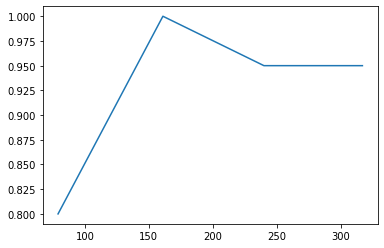

In [150]:

results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

In [145]:
test = fake_news_dataset.sample(1000).reset_index()

In [151]:
ft_model = 'ada:ft-personal-2023-04-18-19-13-19'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']

' Fake'

In [171]:
preds = []
for i in range(20):
    res = openai.Completion.create(model=ft_model, prompt=test['prompt'][i] + '\n\n###\n\n', max_tokens=1, temperature=0)
    preds.append("   Possibly" + res['choices'][0]['text'])
    print(repr(preds[-1]), repr(test['completion'][i]))

'   Possibly Fake' '   Possibly Fake'
'   Possibly Real' '   Possibly Real'
'   Possibly Real' '   Possibly Real'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Real' '   Possibly Real'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Real' '   Possibly Real'
'   Possibly Real' '   Possibly Real'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Real' '   Possibly Real'
'   Possibly Real' '   Possibly Real'
'   Possibly Real' '   Possibly Real'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Fake' '   Possibly Fake'
'   Possibly Real' '   Possibly Real'


In [172]:
from sklearn.metrics import accuracy_score

accuracy_score(preds, test['completion'].iloc[0:20])

1.0

In [176]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=4)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7fa96f5658e0> JSON: {
  " Fake": -0.0010463205,
  " Real": -9.13199,
  " fake": -8.994638,
  "Fake": -7.615216
}